## Sistema recomendador de canciones

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Cargamos los datos y realizamos un análisis exploratorio de los mismos

In [ ]:
ratings = pd.read_csv('ratings_songs.csv')
songs = pd.read_csv('songs.csv')

Podemos buscar una canción si sabemos su nombre con la siguiente función:

In [ ]:
def song_finder(title):
    return songs[songs['title'].str.contains(title)]['title'].tolist()

song_finder('Happy')

In [ ]:
##Vamos a filtrar los ratings para quedarnos solo con valoraciones que corresponden a la peliculas del data set (numeradas del 0 al 603) 
ratings = ratings.loc[ratings['songId'] <= 603]

Podemos contar los elementos distintos con la función Series.nunique(dropna=True) (el parámetro indica si ignorar los valores NaN).

In [ ]:
n_ratings = len(ratings)
n_songs = ratings['songId'].nunique()
n_users = ratings['userId'].nunique()
print(f"Numero de ratings: {n_ratings}")
print(f"Numero de songId's: {n_songs}")
print(f"Numero de users: {n_users}")
print(f"Número medio de ratings por usuario: {round(n_ratings/n_users, 2)}")
print(f"Número medio de ratings por canción: {round(n_ratings/n_songs, 2)}")

In [ ]:
#sns.countplot(x="rating", data=ratings, palette="viridis")
sns.countplot(x="rating", data=ratings)
plt.title("Distribución de los ratings de las canciones", fontsize=14)
plt.show()

In [ ]:
print(f"Rating global medio: {round(ratings['rating'].mean(),2)}.")
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Ratio medio por usuario: {round(mean_ratings.mean(),2)}.")

### 1. Recomendador basado en popularidad
Vamos a hacer un recomendador basado en popularidad.

Usamos __la media bayesiana__ [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average) para evaluar la popularidad de las canciones, la que no está afectada por el número de valoraciones. La media bayesiana es un concepto relacionado con la estadística y la teoría de probabilidad que se utiliza para calcular la media de una distribución de probabilidad a partir de una combinación de la información previa y de la nueva información observada. En contraste con la media aritmética común, que se calcula simplemente promediando los valores observados, la media bayesiana toma en cuenta la incertidumbre inherente a los datos y la incorpora de manera formal en el cálculo de la media.

Para este ejemplo vamos a utilizar la siguiente definición de _Media Bayesiana_:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

Donde:
  - $C$ representa la confianza
  - $m$ representa el conocimiento previo (prior) que en este ejemplo será el rating medio (calculado con todas las canciones). 
  - $N$ es el numero total de ratings para la canción $i$ 
  - $C$ representa el tamaño típico de un data set. En este caso $C$ será el número medio de ratings de las canciones. 

El cálculo de la media bayesiana es útil en situaciones donde queremos combinar información previa con nuevos datos para obtener una estimación más precisa y ajustada de una variable. Esta técnica es especialmente útil en el contexto del aprendizaje automático y la inferencia bayesiana, donde se modelan distribuciones de probabilidad para tomar decisiones basadas en datos y creencias previas.

In [ ]:
song_stats = ratings.groupby('songId')[['rating']].agg(['count', 'mean'])
song_stats.columns = song_stats.columns.droplevel()

In [ ]:
C = song_stats['count'].mean()
m = song_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('songId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['songId', 'bayesian_avg']
song_stats = song_stats.merge(bayesian_avg_ratings, on='songId')

In [ ]:
song_stats = song_stats.merge(songs[['id', 'title']], left_on='songId', right_on='id')
song_stats.sort_values('bayesian_avg', ascending=False).head()

Utilizando la media bayesiana, vemos que `What the Hell`, `Roar`, y `Good as Hell (feat. Ariana Grande) - Remix` son las canciones mejor valoradas. Este resultado tiene mucho más sentido ya que estas canciones son ampliamente aclamadas por la crítica.

In [ ]:
song_stats.sort_values('bayesian_avg', ascending=True).head()

Con el promedio bayesiano, parece que `Higher Love`, `Someone Like You`, y `Treasure` son las canciones peor valoradas.

### 2. Recomendador basado en contenidos teniendo en cuenta los géneros exactos de las canciones

Además de recomendar las canciones más o menos populares del data set podemos hacer una recomendación basada en contenidos. Los datos que tenemos de las canciones son sólo el título, el año y el género, por lo que haremos un recomendador que tenga en cuenta los géneros de las canciones. Esto permitirá enriquecer las recomendaciones de forma personalizada según los gustos específicos. En este caso no se aplica similitud sino simplemente un filtro exacto sobre los géneros.

Recordamos que en el dataset de canciones:
- `top genre` se expresa como una cadena de texto con un carácter " " que separa cada género. 

Vamos a manipular esta cadena para convertirla en una lista, lo que facilitará su análisis.

- `title` actualmente tiene el año entre paréntesis al final. 

Extraeremos el año de cada cadena de título y crearemos una nueva columna para él.

In [ ]:
songs['top genre']

In [ ]:
songs['top genre'] = songs['top genre'].apply(lambda x: x.split(" "))
songs.head()

Vamos a ver cuántos géneros diferentes hay en el dataset y cuántas canciones tenemos de cada género utilizando Counter sobre la Serie de datos de la columna `top genre`. 

In [ ]:
from collections import Counter
genre_frequency = Counter(g for genres in songs['top genre'] for g in genres)
print(f"There are {len(genre_frequency)} genres.")
genre_frequency

In [ ]:
print("Los 5 géneros más comunes son: \n", genre_frequency.most_common(5))

In [ ]:
# songs = pd.read_csv('songs.csv')
def recommender_by_genre(genre):
    songs_grouped = songs.groupby('top genre')
    recomendadas = pd.DataFrame()
    for key, group in songs_grouped:
        recomendadas = pd.concat([recomendadas, group], axis=0)
    songs2 = recomendadas.loc[recomendadas['top genre'] == genre]
    return songs2[['songId', 'title', 'top genre']]

In [ ]:
recommender_by_genre('pop')

### 3. Recomendador basado filtrado colaborativo

Vamos a utilizar filtrado colaborativo para generar recomendaciones para los usuarios. Como hemos visto en clase esta técnica se basa en la premisa de que personas similares tienen gustos similares.
El primer paso es transformar nuestros datos en una matriz usuario-elemento, también conocida como matriz de "utilidad". 
Como hemos visto en clase, en esta matriz, las filas representan a los usuarios y las columnas representan a las canciones. La mejor parte del filtrado colaborativo es que no requiere ninguna información adicional sobre los usuarios o las canciones para generar recomendaciones.

<img src="collaborativeFiltering.png" width=60%/>


La función `create_X()` produce una matriz dispersa X con cuatro diccionarios de mapeo:
- **user_mapper**: mapea el ID del usuario al índice del usuario.
- **song_mapper**: mapea el ID de la canción al índice de la canción.
- **user_inv_mapper**: mapea el índice del usuario al ID del usuario.
- **song_inv_mapper**: mapea el índice de la canción al ID de la canción.

Necesitamos estos diccionarios porque establecen la correspondencia entre qué fila/columna de la matriz de utilidad se relaciona con qué ID de usuario/canción.

Esta matriz tiene muchos valores desconocidos y para almacenar la matriz de utilidad (user-item) utilizaremos un tipo de matriz específico [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) que almacena datos dispersos de forma eficiente.

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Genera una matriz dispersa a partir del marco de datos de calificaciones.
    
    Argumentos:
        df: dataframe de pandas que contiene 3 columnas (userId, songId, rating)
    
    Devoluciones:
        X: matriz dispersa
        user_mapper: dict que asigna las identificaciones de usuario a los índices de usuario
        user_inv_mapper: dict que asigna índices de usuario a ID de usuario
        song_mapper: dict que asigna las identificaciones de canciones a los índices de canciones
        song_inv_mapper: dict que asigna índices de canciones a ID de canciones
        
    """
    M = df['userId'].nunique()
    N = df['songId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    song_mapper = dict(zip(np.unique(df["songId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    song_inv_mapper = dict(zip(list(range(N)), np.unique(df["songId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [song_mapper[i] for i in df['songId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, song_mapper, user_inv_mapper, song_inv_mapper

In [ ]:
# Creamos en X una matriz de utilidad usando nuestros datos de ratings. Además disponemos de estructuras para indexar los datos dispersos.
X, user_mapper, song_mapper, user_inv_mapper, song_inv_mapper = create_X(ratings)

Para calcular la dispersión (sparsity) de esta matriz se divide el número total de elementos no vacíos entre el número total de elementos.  El número de elementos almacenados (no vacíos) en nuestra matriz es equivalente al número de ratings en nuestro conjunto de datos. 
`csr_matrix.nnz` cuenta los valores almacenados (no vacíos) en la matriz de utilidad. El resto de celdas están vacías.

Este es problema del inicio en frío (**cold start**) que ocurre cuando hay nuevos usuarios y canciones en nuestra matriz que no tienen calificaciones. Es útil verificar qué usuarios y canciones tienen pocas (o ninguna) interacciones. 
Vamos a ver que en estos datos de songlens no hay ningún usuario ni canción sin interacciones pero sí hay algunas que tienen muy pocas.

In [ ]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

In [ ]:
n_ratings_per_user = X.getnnz(axis=1)

print(f"El usuario más activo ha valorado {n_ratings_per_user.max()} canciones.")
print(f"El usuario menos activo ha valorado {n_ratings_per_user.min()} canciones.")

In [ ]:
n_ratings_per_song = X.getnnz(axis=0)

print(f"La canción más valorada tiene {n_ratings_per_song.max()} ratings.")
print(f"La canción menos valorada tiene {n_ratings_per_song.min()} ratings.")

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Número de ratings por usuario", fontsize=14)
plt.xlabel("Número de ratings por usuario")
plt.ylabel("Densidad")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_song, fill=True)
plt.xlim(0)
plt.title("Numero de Ratings por canción", fontsize=14)
plt.xlabel("Número de ratings por canción")
plt.ylabel("Densidad")
plt.show()

Vamos a normalizar nuestros datos.
    - Definimos el sesgo usuario-elemento como: $b_{ui} = \mu + b_{u} + b_{i}$
    - Realizamos la normalización de la media restando $b_{i}$ a los ratings de cada canción.

In [ ]:
sum_ratings_per_song = X.sum(axis=0)
mean_rating_per_song = sum_ratings_per_song/n_ratings_per_song
mean_rating_per_song

Ahora que tenemos la calificación promedio para cada canción, vamos a restar esto de nuestra matriz de utilidad. Para hacerlo, necesitamos expandir nuestra matriz 1D `mean_rating_per_song` en una matriz con la misma forma que nuestra matriz de utilidad `(n_users, n_songs)`. 

El método `tile` de Numpy es útil para esta tarea.

In [ ]:
X_mean_song = np.tile(mean_rating_per_song, (X.shape[0],1))

In [ ]:
X_mean_song.shape

`X_mean_song` es una matriz de forma (n_users, n_songs) en la que cada columna está poblada con la calificación promedio de una canción específica.

Podemos normalizar fácilmente nuestra matriz X restando `X_mean_song` de la matriz original `X`.

In [ ]:
X_norm = X - csr_matrix(X_mean_song)

Como era de esperar, los valores de `X_norm` son diferentes de los de `X`. Las celdas que estaban vacías en la matriz original ahora están reemplazadas por valores negativos que representan la calificación promedio de una canción específica.

In [ ]:
print("Original X:", X[0].todense())
print("Normalized X:", X_norm[0].todense())

#### 3.1.  Recomendaciones con filtrado colaborativo Item-item 

Vamos a encontrar las $k$ canciones que tienen los vectores de participación de usuarios más similares a la canción $i$.
Utilizaremos el método k-NearestNeighbors (K-NN) de la librería sklearn de python. La librería tiene implementadas algunas medidas de similitud (como la del coseno vista en clase) para comparar los vectores item-item o user-user. 
Puedes ver la documentación en https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors


In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_songs(song_id, X, song_mapper, song_inv_mapper, k, metric='cosine'):
    """
    Encuentra los k vecinos más cercanos para una canción dada.
    
    Argumentos:
        song_id: id de la canción de interés
        X: matriz de utilidad user-item
        k: número de canciones similares que queremos recuperar
        métrica: métrica de distancia para los cálculos de kNN
    
    Salida: devuelve una lista de k ID de canciones similares
    """
    X = X.T
    neighbour_ids = []
    
    song_ind = song_mapper[song_id]
    song_vec = X[song_ind]
    if isinstance(song_vec, (np.ndarray)):
        song_vec = song_vec.reshape(1,-1)
    # usamos k+1 porque la salida kNN incluye la canción de ID = songId
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(song_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(song_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_songs()` calcula para un cierto `songId` y una matriz `X`, una lista de $k$ canciones que son similares a la canción `songId` según los vectores de ratings de las canciones.
`find_similar_songs()` devuelve una lista de los `songId` que son más similares a la canción dada. Vamos a convertirlos a títulos para entender mejor los resultados creando un diccionario con `songId` y `title`.

In [ ]:
similar_songs = find_similar_songs(1, X_norm, song_mapper, song_inv_mapper, k=10)
similar_songs

Estas son las K=10 canciones más similares. Como queremos saber los títulos de las canciones vamos a crear un mapeado entre songId y los títulos para que los resultados sean más fáciles de interpretar. 

In [ ]:
song_titles = dict(zip(songs['id'], songs['title']))

song_id = 1

similar_songs = find_similar_songs(song_id, X_norm, song_mapper, song_inv_mapper, metric='cosine', k=10)
song_title = song_titles[song_id]

print(f" Porque has visto ... {song_title} ... te recomendamos:")
for i in similar_songs:
    print(song_titles[i])

Los resultados anteriores muestran las 10 canciones más similares a Toy Story. La mayoría de las canciones de esta lista son canciones _familiares_ de la década de 1990, lo que parece bastante razonable. Hay que tener en cuenta que estas recomendaciones se basan únicamente en las calificaciones de los usuarios. En este enfoque colaborativo **no se utilizan características específicas de las canciones** como sus géneros. Si queremos tener en cuenta las características deberíamos usar un enfoque basado en contenidos (_content-based_) como hemos hecho antes. Tambien puedes combinar las dos aproximaciones. 

Se pueden hacer distintas pruebas con otras métricas kNN utilizando distancia "manhattan" o "euclidea" en vez de la similitud del "coseno". Observa que los resultados son diferentes. Habría que evaluar cual de ellas proporciona unos resultados mejores.


In [ ]:
song_id = 1

similar_songs = find_similar_songs(song_id, X_norm, song_mapper, song_inv_mapper, metric='euclidean', k=10)
song_title = song_titles[song_id]

print(f"Porque has visto {song_title} te recomendamos:")
for i in similar_songs:
    print(song_titles[i])

### 4. Recomendador basado en contenidos usando similitud del coseno

El filtrado colaborativo se basa únicamente en las interacciones entre el usuario y las canciones. El problema con este enfoque es que los usuarios nuevos o las canciones que no han tenido interaciones (valoraciones) o han tenido muy pcoas quedan excluidos del sistema de recomendación (no tenemos datos sobre los usuarios, ni sobre sus gustos). Esto se llama problema de arranque en frío o _cold-start_. El filtrado basado en contenido (content-based) es una forma de manejar este problema generando recomendaciones basadas en las características del usuario y del elemento.

Como una canción puede tener varios géneros vamos a convertir la columna de los géneros de las canciones en características binarias. Lo que queremos es que cada género tenga su propia columna binaria que se rellena con 0 o 1 en la fila de cada canción según tenga o no un géneros. Esta representación con un vector binario de generos permite aplicar la similitud del coseno para comparar dos canciones según los géneros que comparten.

In [ ]:
n_songs = songs['id'].nunique()
print(f"Hay {n_songs} canciones en el dataset.")

In [ ]:
genres = set(g for G in songs['top genre'] for g in G)

for g in genres:
    songs[g] = songs["top genre"].transform(lambda x: int(g in x))
    
song_genres = songs.drop(columns=['id', 'title','top genre'])

In [ ]:
song_genres.head()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

cosine_sim = cosine_similarity(song_genres, song_genres)
print(f"Dimensiones de la matriz de similitud del coseno entre los géneros: {cosine_sim.shape}")

Las dimensiones de nuestra matriz de similitud coseno son $M \times M$ donde $M$ representa el número total de canciones.

In [ ]:
# Mostramos la matriz de similitudes entre los géneros. Observa como la columna central es 1.
cosine_sim

In [ ]:
def song_finder(title):
    return songs[songs['title'].str.contains(title)]['title'].tolist()

song_finder('Toy Story')

In [ ]:
song_idx = dict(zip(songs['title'], list(songs.index)))
title = song_finder('Toy Story')[0]
n_recommendations = 10

idx = song_idx[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_songs = [i[0] for i in sim_scores]

print(f"Recomendaciones similares a {title} según la similitud entre sus géneros:")
songs['title'].iloc[similar_songs]

Con este enfoque basado en contenidos asumimos que dos canciones son "similares" si tienen más géneros similares. Estas recomendaciones de "canciones similares" se basan únicamente en los metadatos de nuestro conjunto de datos de canciones. 

Realiza alguna prueba más con otras canciones que te gusten y observa si las recomendaciones son adecuadas.

 ### 5. Recomendador colaborativo user-user usando similitud de Pearson

En esta última versión vamos a implementar la medida de similitud de Pearson para obtener los usuarios más similares. 
En esta versión la recomendación puede usar las preferencias de usuarios parecidos calculando para ello la similitud entre sus vectores de valoraciones. 

In [ ]:
def getUserVotes(user):
    return ratings.loc[ratings['userId'] == user, 'rating'].values

def getVotedsongs(user):
    return ratings.loc[ratings['userId'] == user, 'songId'].values

def getRating(userId, songId):
    data  = ratings.loc[(ratings['userId'] == userId) & (ratings['songId'] == songId), 'rating']
    if len(data)==0:
        return 0
    else:
        return data.iloc[0]
    
def getNormalizedRating(userId, songId):
    rating = getRating(userId, songId)
    if rating == 0:
        return rating
    else:
        return rating-getUserVotes(userId).mean()

In [ ]:
## Calcula la similitud de dos usuarios dados.
def sim(a,u):
    a_votedsongs = getVotedsongs(a)
    u_votedsongs = getVotedsongs(u)

    a_votes  = getUserVotes(a)
    u_votes  = getUserVotes(u)

    a_mean = a_votes.mean()
    u_mean = u_votes.mean()

    commonVotedsongs = [value for value in a_votedsongs if value in u_votedsongs]
    s = len(commonVotedsongs)
    if s==0:
        return 0
    
    a_votes = [getRating(a, songId) for songId in commonVotedsongs]
    u_votes = [getRating(u, songId) for songId in commonVotedsongs]
    a_votes_norm = [v - a_mean for v in a_votes]
    u_votes_norm = [v - u_mean for v in u_votes]
    
    dot = np.multiply(a_votes_norm, u_votes_norm)
    sum_dot = np.sum(dot)
    std  = (np.std(a_votes) * np.std(u_votes))
    if std==0:
        std = 1
    
    f  = 50 #Debería ser la media de canciones en común de todo el dataset
    sim = sum_dot * s / std / f
    return sim

In [ ]:
# Recupera k usuarios más similares al usuario con idUSer=a
def getKMostSimilarUsers(a,k):
    users = ratings.userId.unique()
    similarity = [sim(a,u) for u in users]
    data = {'User': users,
        'Similarity': similarity}
    simTable = pd.DataFrame(data)
    simTable = simTable[simTable.User !=a]
    simTable = simTable.sort_values('Similarity',ascending=False)
    return simTable.head(k)    

In [ ]:
getKMostSimilarUsers(1,5)

### Evaluación de recomendadores

Podemos observar cómo funciona el sistema para hacernos a la idea de cómo funciona, pero ¿cómo sabemos si nuestras recomendaciones son realmente buenas? 
Una manera de evaluar nuestro sistema es probarlo con usuarios reales haciendo pruebas de usabilidad, donde podemos obtener comentarios directos de los usuarios. Sin embargo, esta opción no siempre está disponible, lo que significa que debemos utilizar métricas calculadas sobre los resultados.

En el aprendizaje automático tradicional, evaluamos un modelo dividiendo nuestros datos en dos conjuntos: 
- "conjunto de entrenamiento" 
- "conjunto de validación"
    
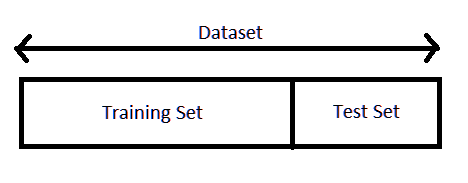

Y se puede hacer validación cruzada repitiendo este proceso de dividir los datos en dos conjuntos varias veces y luego hacer la media de los resultados.

En los sistemas de recomendación generamos nuestro "conjunto de entrenamiento" enmascarando interacciones aleatorias en nuestra matriz usuario-elemento. En otras palabras, hacemos como que no sabemos si a un usuario le gustó una cierta canción "A", pero en realidad sí lo sabemos. Una vez que entrenamos nuestro modelo y generamos nuestras predicciones de calificación, podemos comparar nuestra calificación prevista con la calificación real.

Hay varias formas de comparar la calificación (rating) calculado por el sistema con la calificación real (que sabemos). Las más comunes son:
    
1) Error cuadrático medio (RMSE, Root Mean Squared Error): $\text{RMSE} = \sqrt{\frac{\Sigma^N_{i=1}(y-\hat{y})^2}{N}}$

2) Precision: $\text{Precision} = \frac{TP}{TP+FP}$

3) Recall: $\text{Recall} = \frac{TP}{TP+FN}$